# 03 - Modelling and Evaluating

## Objective
Answer Business Requirement 2:
> The client is interested to predict whether a cherry leaf is healthy or contains powdery mildew.

---

## Inputs
- inputs/cherry_leaves_split/train
- inputs/cherry_leaves_split/val
- inputs/cherry_leaves_split/test
- outputs/02_data_visualisation/image_shape.pkl

## Outputs
- Model saved as `.h5`
- Class indices saved as `.pkl`
- Learning curves
- Model evaluation score

## Imports

In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from matplotlib.image import imread

sns.set_style("whitegrid")

## Set paths

In [22]:
cwd = os.getcwd()
print("Working directory set:", cwd)

train_path = "/workspaces/Mildew-Detection-in-Cherry-Leaves/inputs/cherry_leaves_split/train"
val_path = "/workspaces/Mildew-Detection-in-Cherry-Leaves/inputs/cherry_leaves_split/val"
test_path = "/workspaces/Mildew-Detection-in-Cherry-Leaves/inputs/cherry_leaves_split/test"

version = "03_modelling_and_evaluating"
file_path = f"outputs/{version}"
os.makedirs(file_path, exist_ok=True)

Working directory set: /workspaces/Mildew-Detection-in-Cherry-Leaves/jupyter_notebooks


## Labels and image shape

In [23]:
labels = os.listdir(train_path)
print("Project Labels:", labels)

image_shape = joblib.load("/workspaces/Mildew-Detection-in-Cherry-Leaves/outputs/02_data_visualisation/image_shape.pkl")
image_shape

Project Labels: ['healthy', 'powdery_mildew']


(256, 256, 3)

## Image count distribution

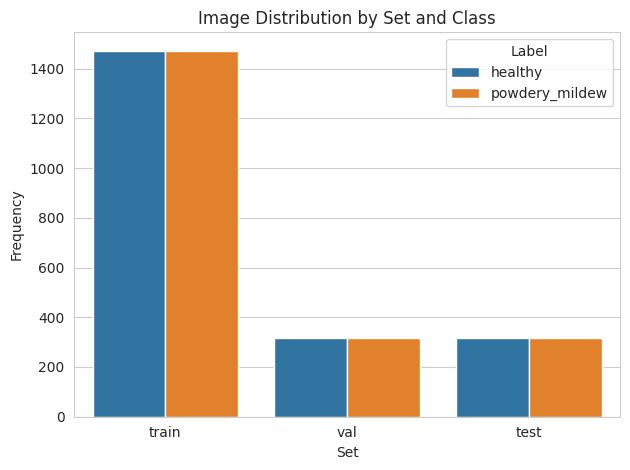

In [24]:
df_freq = pd.DataFrame()
for folder in ['train', 'val', 'test']:
    for label in labels:
        count = len(os.listdir(f"/workspaces/Mildew-Detection-in-Cherry-Leaves/inputs/cherry_leaves_split/{folder}/{label}"))
        df_freq = pd.concat([df_freq, pd.DataFrame([{
            "Set": folder,
            "Label": label,
            "Frequency": count
        }])])

sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.title("Image Distribution by Set and Class")
plt.tight_layout()
plt.savefig(f"{file_path}/labels_distribution.png", dpi=150)
plt.show()

## Image Augmentation

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 20

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory(train_path, target_size=image_shape[:2], batch_size=batch_size, class_mode='binary')
val_set = val_test_datagen.flow_from_directory(val_path, target_size=image_shape[:2], batch_size=batch_size, class_mode='binary')
test_set = val_test_datagen.flow_from_directory(test_path, target_size=image_shape[:2], batch_size=batch_size, class_mode='binary')

Found 2944 images belonging to 2 classes.
Found 630 images belonging to 2 classes.
Found 634 images belonging to 2 classes.


## Preview augmented images

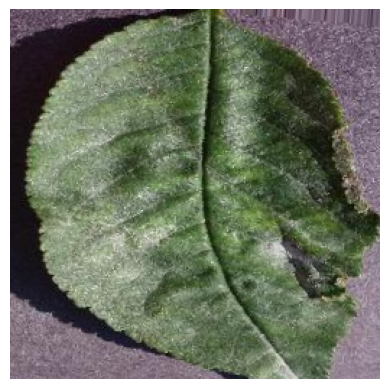

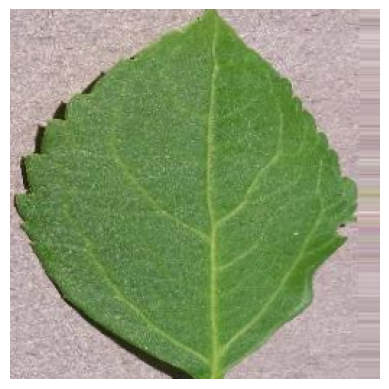

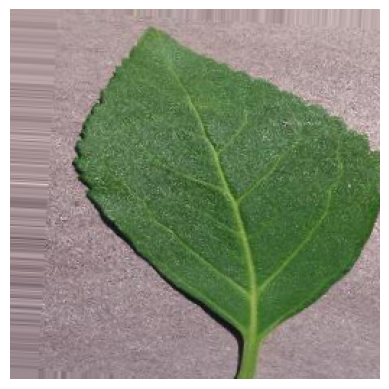

In [26]:
for _ in range(3):
    img, label = next(train_set)
    plt.imshow(img[0])
    plt.axis("off")
    plt.show()

## Save class indices

In [27]:
joblib.dump(train_set.class_indices, f"{file_path}/class_indices.pkl")

['outputs/03_modelling_and_evaluating/class_indices.pkl']

## Create CNN Model

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=image_shape),
        MaxPooling2D(2, 2),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,429,377 (28.34 MB)

 Trainable params: 7,429,377 (28.34 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [29]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(
    train_set,
    epochs=25,
    steps_per_epoch=len(train_set),
    validation_data=val_set,
    validation_steps=len(val_set),
    callbacks=[early_stop],
    verbose=1
)

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 125s 832ms/step - accuracy: 0.6694 - loss: 0.7632 - val_accuracy: 0.7714 - val_loss: 0.3978
Epoch 2/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 141s 829ms/step - accuracy: 0.9443 - loss: 0.1707 - val_accuracy: 0.9841 - val_loss: 0.0568
Epoch 3/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 122s 823ms/step - accuracy: 0.9833 - loss: 0.0599 - val_accuracy: 0.9794 - val_loss: 0.0627
Epoch 4/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 122s 824ms/step - accuracy: 0.9718 - loss: 0.0935 - val_accuracy: 0.9921 - val_loss: 0.0341
Epoch 5/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 122s 822ms/step - accuracy: 0.9794 - loss: 0.0613 - val_accuracy: 0.9905 - val_loss: 0.0482
Epoch 6/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 123s 829ms/step - accuracy: 0.9879 - loss: 0.0423 - val_accuracy: 0.9905 - val_loss: 0.0411
Epoch 7/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 122s 826ms/step - accuracy: 0.9838 - loss: 0.0649 - val_accuracy: 0.9905 - val_loss: 0.0302
Epoch 8/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 123s 827ms/step - accuracy: 0.9852 -

## Save the model

In [42]:
model.save("/workspaces/Mildew-Detection-in-Cherry-Leaves/jupyter_notebooks/outputs/v1/cherry_leaf_mildew_model.h5")

## Learning Curves

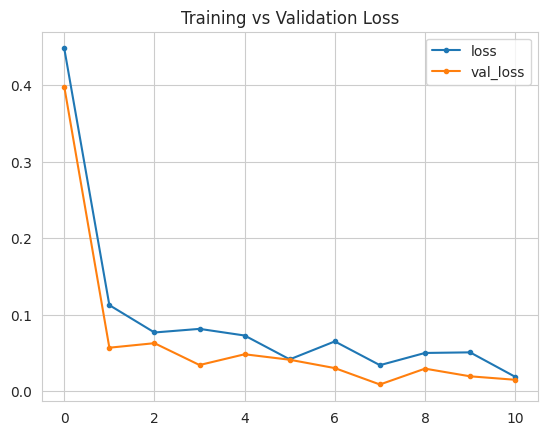

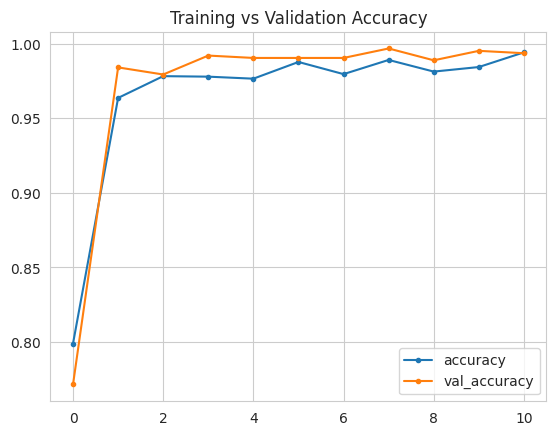

In [43]:
loss_df = pd.DataFrame(history.history)

loss_df[['loss', 'val_loss']].plot(style='.-')
plt.title("Training vs Validation Loss")
plt.savefig(f"{file_path}/training_loss.png", dpi=150)
plt.show()

loss_df[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Training vs Validation Accuracy")
plt.savefig(f"{file_path}/training_accuracy.png", dpi=150)
plt.show()

## Evaluate on Test Set

In [44]:
from tensorflow.keras.models import load_model
import joblib

# Fix the path to where your model was actually saved
model = load_model("/workspaces/Mildew-Detection-in-Cherry-Leaves/jupyter_notebooks/outputs/v1/cherry_leaf_mildew_model.h5")

test_eval = model.evaluate(test_set)
print("Test Set Evaluation (Loss, Accuracy):", test_eval)

joblib.dump(test_eval, "/workspaces/Mildew-Detection-in-Cherry-Leaves/jupyter_notebooks/outputs/v1/evaluation.pkl")

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 211ms/step - accuracy: 0.9985 - loss: 0.0038
Test Set Evaluation (Loss, Accuracy): [0.008749566040933132, 0.9968454241752625]


['/workspaces/Mildew-Detection-in-Cherry-Leaves/jupyter_notebooks/outputs/v1/evaluation.pkl']

## Predict on a random image

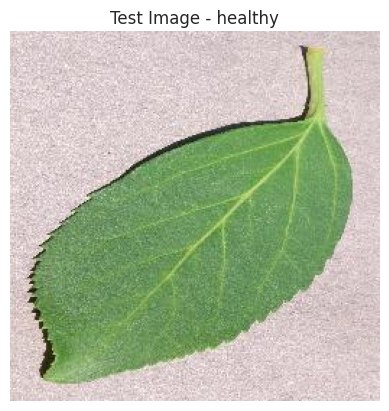

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
Predicted: healthy (1.00 confidence)


: 

In [ ]:
from tensorflow.keras.preprocessing import image

pointer = 10
label = labels[0]
img_file = os.listdir(f"{test_path}/{label}")[pointer]
img_path = os.path.join(test_path, label, img_file)

pil_img = image.load_img(img_path, target_size=image_shape[:2])
plt.imshow(pil_img)
plt.axis("off")
plt.title(f"Test Image - {label}")
plt.show()

img_array = image.img_to_array(pil_img)
img_array = np.expand_dims(img_array, axis=0) / 255

pred_proba = model.predict(img_array)[0, 0]
class_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = class_map[int(pred_proba > 0.5)]

if pred_class == class_map[0]:
    pred_proba = 1 - pred_proba

print(f"Predicted: {pred_class} ({pred_proba:.2f} confidence)")

## Push files to repo